# Projet 7

In [1]:
import time

start_notebook = time.time()

In [2]:
# Zone installation packages :
#%pip install pandas numpy matplotlib seaborn missingno plotly
#%pip install emoji

___
## Command Git

- echo "# OC_AI_Engineer_P7" >> README.md
- git init
- git add README.md
- git commit -m "Mise à jour du notebook"
- git branch -M main
- git remote add origin https://github.com/AnthonyJVID/OC_AI_Engineer_P7.git
- git push -u origin main
___
#### Vérification des commandes
- **git remote** - Vérifie le dépot
- **git add** - ajoute des fichier au suivi
- **git commit** -m "Message des modifications" - Crée un commit
- **git push origin main/master** - Pousse les modification sur Github

## Command MLFlow
mlflow server \
--backend-store-uri sqlite:///C:/Users/icema/OpenClassrooms/AI_Engineer/.venv7/MLflow/mlflow.db \
--default-artifact-root file:///C:/Users/icema/OpenClassrooms/AI_Engineer/.venv7/MLflow/MLruns \
--host 127.0.0.1 \
--port 5000

In [3]:
# Importation des librairies
import sys
import os
import re
import string
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import plotly
import plotly.express as px
import nltk
import mlflow
import mlflow.sklearn
import emoji
import tensorflow_hub as hub
import tensorflow as tf
import logging
import fasttext.util



from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer, PorterStemmer
from gensim.models import FastText
from gensim.models import KeyedVectors
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Dense, Embedding, LSTM, Input, Bidirectional, Dropout, GRU
from keras.layers import GlobalMaxPooling1D, Reshape
from tensorflow.keras.models import Sequential, load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from plot_keras_history import show_history, plot_history
from transformers import BertTokenizer, TFBertForSequenceClassification, TFAutoModel, AutoTokenizer
from mlflow.models.signature import infer_signature



# URI de suivi vers le serveur MLflow (local)
mlflow.set_tracking_uri("http://127.0.0.1:5000")

# Vérification si l'expérience existe
experiment = mlflow.get_experiment_by_name("OC_Project7")
if experiment is None:
    experiment_id = mlflow.create_experiment("OC_Project7")
else:
    experiment_id = experiment.experiment_id



nltk.download("wordnet")
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("punkt_tab")



# Réduire les avertissements liées a TF
logging.getLogger("tensorflow").setLevel(logging.ERROR)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\icema\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\icema\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\icema\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\icema\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [4]:
# Information sur l'environnement virtuel :
print("Version des librairies :")
print("Python        : " + sys.version)
print("Pandas        : " + pd.__version__)
print("NumPy         : " + np.version.__version__)
print("Matplotlib    : " + matplotlib.__version__)
print("Seaborn       : " + sns.__version__)
print("missingno     : " + msno.__version__)
print("plotly        : " + plotly.__version__)
print("Tensorflow    : " + tf.__version__)
print("Tensorflow_hub: " + hub.__version__)

Version des librairies :
Python        : 3.12.4 (tags/v3.12.4:8e8a4ba, Jun  6 2024, 19:30:16) [MSC v.1940 64 bit (AMD64)]
Pandas        : 2.2.3
NumPy         : 1.26.4
Matplotlib    : 3.10.0
Seaborn       : 0.13.2
missingno     : 0.5.2
plotly        : 5.24.1
Tensorflow    : 2.18.0
Tensorflow_hub: 0.16.1


In [5]:
# Paramètre d'affichage :
pd.options.display.max_rows = 200
pd.options.display.max_columns = 200

# style de titres
style = {"family": "Georgia",
        "color":  "darkblue",
        "weight": "bold",
        "size": 15,
        }

## Fonctions Utilitaires

In [6]:
def clean_text(text):
    # Convertir le texte en minuscules
    text = text.lower()

    # Supprimer les URLs et les mentions
    text = re.sub(r"https?://\S+|www\.\S+|@\w+", " ", text)

    # Remplacer les emojis par leur signification
    text = emoji.demojize(text)

    # Supprimer les hashtags tout en gardant leur contenu
    text = re.sub(r"#(\w+)", r"\1", text)

    # Supprimer les chiffres et les ponctuations
    text = re.sub(r"\d+", " ", text)
    text = re.sub(r"[^\w\s]", " ", text)

    # Supprimer les répétitions excessives de caractères
    text = re.sub(r"(.)\1{2,}", r"\1", text)

    # Tokeniser et supprimer les stopwords
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words("english"))
    tokens = [word for word in tokens if word not in stop_words]

    # Rejoindre les mots nettoyés
    cleaned_text = " ".join(tokens)

    return cleaned_text

def old_clean_text(text):
    # Convertir le texte en minuscules
    text = str(text).lower()

    # Supprimer les chiffres, les balises HTML et les liens URL
    text = re.sub(r"\d+|\[.*?\]|https?://\S+|www\.\S+", " ", text)

    # Supprimer les emojis et les symboles divers
    text = re.sub(r"["
                u"\U0001F600-\U0001F64F"   # Emoticônes
                u"\U0001F300-\U0001F5FF"   # Symboles et pictogrammes
                u"\U0001F680-\U0001F6FF"   # Symboles de transport/cartes
                u"\U0001F1E0-\U0001F1FF"   # Drapeaux (iOS)
                u"\u200d"                  # Jointure à largeur zéro
                u"\u2640-\u2642"           # Symboles de genre
                u"\U000024C2-\U0001F251"   # Caractères enfermés
                "]+", " ", text)

    # Tokeniser le texte
    tokens = word_tokenize(text)

    # Supprimer les stopwords
    stop_words = set(stopwords.words("english"))
    tokens = [word for word in tokens if word not in stop_words]

    # Rejoindre les tokens nettoyés
    cleaned_text = " ".join(tokens)

    return cleaned_text

def wordcloud(tweets, titre):
    tout_texte = " ".join(tweets)
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(tout_texte)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title(titre, fontsize=14)
    plt.axis("off")
    plt.show()

def load_glove_embeddings(chemin_fichier):
    embeddings_index = {}
    with open(chemin_fichier, "r", encoding="utf8") as f:
        for ligne in f:
            valeurs = ligne.split()
            mot = valeurs[0]
            vecteur = np.asarray(valeurs[1:], dtype="float32")
            embeddings_index[mot] = vecteur
    return embeddings_index

# Ajustement en fonction du choix
chemin_glove_25 = "C:/Users/icema/OpenClassrooms/AI_Engineer/.venv7/glove.twitter.27B.25d.txt"
glove_embeddings = load_glove_embeddings(chemin_glove_25)

chemin_glove_50 = "C:/Users/icema/OpenClassrooms/AI_Engineer/.venv7/glove.twitter.27B.50d.txt"
glove_embeddings = load_glove_embeddings(chemin_glove_50)

chemin_glove_100 = "C:/Users/icema/OpenClassrooms/AI_Engineer/.venv7/glove.twitter.27B.100d.txt"
glove_embeddings = load_glove_embeddings(chemin_glove_100)

chemin_glove_200 = "C:/Users/icema/OpenClassrooms/AI_Engineer/.venv7/glove.twitter.27B.200d.txt"
glove_embeddings = load_glove_embeddings(chemin_glove_200)

def load_fasttext_embeddings(chemin_fichier):
    embeddings_index = {}
    with open(chemin_fichier, "r", encoding="utf8") as f:
        # La première ligne peut contenir la taille du vocabulaire et la dimension
        premiere_ligne = True
        for ligne in f:
            if premiere_ligne:
                premiere_ligne = False
                continue
            valeurs = ligne.rstrip().split(" ")
            mot = valeurs[0]
            vecteur = np.asarray(valeurs[1:], dtype="float32")
            embeddings_index[mot] = vecteur
    return embeddings_index

def train_evaluate_simple_model(run_name, model, X_train_vec, y_train, X_val_vec, y_val):
    model_name = type(model).__name__

    # Initialisation d'un run avec le nom donné
    with mlflow.start_run(run_name=run_name):
        # Entraînement du modèle
        model.fit(X_train_vec, y_train)

        # Prédiction et évaluation du modèle sur l'ensemble de validation
        y_val_pred = model.predict(X_val_vec)
        accuracy_val = accuracy_score(y_val, y_val_pred)
        recall_val = recall_score(y_val, y_val_pred, average="weighted")
        f1_val = f1_score(y_val, y_val_pred, average="weighted")
        auc_val = roc_auc_score(y_val, y_val_pred)
        tn, fp, fn, tp = confusion_matrix(y_val, y_val_pred).ravel()
        specificity_val = tn / (tn+fp)

        # Enregistrement des paramètres et des métriques dans MLflow
        mlflow.log_param("model", model_name)
        mlflow.log_metric("accuracy_val", accuracy_val)
        mlflow.log_metric("recall_val", recall_val)
        mlflow.log_metric("f1_val", f1_val)
        mlflow.log_metric("auc_val", auc_val)
        mlflow.log_metric("specificity_val", specificity_val)

        # Prédiction et évaluation du modèle sur l'ensemble de test
        y_test_pred = model.predict(X_test_vec)
        accuracy_test = accuracy_score(y_test, y_test_pred)
        recall_test = recall_score(y_test, y_test_pred, average="weighted")
        f1_test = f1_score(y_test, y_test_pred, average="weighted")
        auc_test = roc_auc_score(y_test, y_test_pred)
        tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()
        specificity_test = tn / (tn+fp)

        # Enregistrement des métriques de l'ensemble de test dans MLflow
        mlflow.log_metric("accuracy_test", accuracy_test)
        mlflow.log_metric("recall_test", recall_test)
        mlflow.log_metric("f1_test", f1_test)
        mlflow.log_metric("auc_test", auc_test)
        mlflow.log_metric("specificity_test", specificity_test)


        # Enregistrement du modèle dans MLflow
        mlflow.sklearn.log_model(model, model_name)
        mlflow.end_run()

def train_evaluate_neural_model(name_exp, run_name, model, X_train_pad, y_train, X_test_pad, y_test, X_val_pad, y_val):
    # Définir le nom de l'expérience
    mlflow.set_experiment(name_exp)

    # Commencer une nouvelle "run" MLflow
    with mlflow.start_run(run_name=run_name):
        # Enregistrer les paramètres du modèle
        mlflow.log_param("num_layers", len(model.layers))
        mlflow.log_param("optimizer", model.optimizer.get_config()["name"])

        # Création du callback
        model_save_path = "model_best_weights.keras"
        checkpoint = ModelCheckpoint(model_save_path, monitor="val_loss", verbose=1, save_best_only=True, mode="min")
        es = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=10)
        callbacks_list = [checkpoint, es]

        # Entraînement du modèle
        history = model.fit(X_train_pad, y_train, epochs=50, batch_size=64, callbacks=callbacks_list, validation_data=(X_test_pad, y_test), verbose=1)

        # Score du dernier epoch
        loss, accuracy_train = model.evaluate(X_train_pad, y_train, verbose=True)
        print("Training Accuracy: {:.4f}".format(accuracy_train))
        print()
        loss, accuracy_test = model.evaluate(X_test_pad, y_test, verbose=True)
        print("Validation Accuracy:  {:.4f}".format(accuracy_test))

        # Enregistrer les métriques du modèle
        mlflow.log_metric("train_accuracy", accuracy_train)
        mlflow.log_metric("test_accuracy", accuracy_test)

        # Score de l'epoch optimal
        model.load_weights(model_save_path)
        loss, accuracy_val = model.evaluate(X_val_pad, y_val, verbose=False)
        print("Validation Accuracy :  {:.4f}".format(accuracy_val))

        # Enregistrer les métriques du modèle
        mlflow.log_metric("val_accuracy", accuracy_val)

        # Enregistrer le modèle
        mlflow.keras.log_model(model, "model")

        # Prédiction et évaluation du modèle
        y_pred_train = (model.predict(X_train_pad) > 0.5).astype("int32")
        y_pred_test = (model.predict(X_test_pad) > 0.5).astype("int32")
        y_pred_val = (model.predict(X_val_pad) > 0.5).astype("int32")

        # Calcul des métriques pour l'ensemble de test
        y_pred_prob_test = model.predict(X_test_pad)
        recall_test = recall_score(y_test, y_pred_test, average="weighted")
        f1_test = f1_score(y_test, y_pred_test, average="weighted")
        auc_test = roc_auc_score(y_test, y_pred_prob_test)
        tn_test, fp_test, fn_test, tp_test = confusion_matrix(y_test, y_pred_test).ravel()
        specificity_test = tn_test / (tn_test+fp_test)

        print("\nTest Metrics:")
        print(f"Accuracy: {accuracy_test}")
        print(f"Recall: {recall_test}")
        print(f"F1 Score: {f1_test}")
        print(f"AUC: {auc_test}")
        print(f"Specificity: {specificity_test}")

        # Enregistrement des métriques de l'ensemble de test dans MLflow
        mlflow.log_metric("accuracy_test", accuracy_test)
        mlflow.log_metric("recall_test", recall_test)
        mlflow.log_metric("f1_test", f1_test)
        mlflow.log_metric("auc_test", auc_test)
        mlflow.log_metric("specificity_test", specificity_test)

        # Calcul des métriques pour l'ensemble de validation
        y_pred_prob_val = model.predict(X_val_pad)
        recall_val = recall_score(y_val, y_pred_val, average="weighted")
        f1_val = f1_score(y_val, y_pred_val, average="weighted")
        auc_val = roc_auc_score(y_val, y_pred_prob_val)
        tn_val, fp_val, fn_val, tp_val = confusion_matrix(y_val, y_pred_val).ravel()
        specificity_val = tn_val / (tn_val+fp_val)

        print("\nValidation Metrics:")
        print(f"Accuracy: {accuracy_val}")
        print(f"Recall: {recall_val}")
        print(f"F1 Score: {f1_val}")
        print(f"AUC: {auc_val}")
        print(f"Specificity: {specificity_val}")

        # Enregistrement des paramètres et des métriques dans MLflow
        mlflow.log_metric("accuracy_val", accuracy_val)
        mlflow.log_metric("recall_val", recall_val)
        mlflow.log_metric("f1_val", f1_val)
        mlflow.log_metric("auc_val", auc_val)
        mlflow.log_metric("specificity_val", specificity_val)

        show_history(history)
        plot_history(history, path="standard.png")
        plt.close()

def bert_inp_fct(sentences, bert_tokenizer, max_length) :
    input_ids=[]
    token_type_ids = []
    attention_mask=[]
    bert_inp_tot = []

    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                            add_special_tokens = True,
                                            max_length = max_length,
                                            padding="max_length",
                                            return_attention_mask = True,
                                            return_token_type_ids=True,
                                            truncation=True,
                                            return_tensors="tf")

        input_ids.append(bert_inp["input_ids"][0])
        token_type_ids.append(bert_inp["token_type_ids"][0])
        attention_mask.append(bert_inp["attention_mask"][0])
        bert_inp_tot.append((bert_inp["input_ids"][0],
                            bert_inp["token_type_ids"][0],
                            bert_inp["attention_mask"][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)

    return input_ids, token_type_ids, attention_mask, bert_inp_tot


# Fonction de création des features
def feature_BERT_fct(model, model_type, sentences, max_length, b_size, mode="HF") :
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    time1 = time.time()

    last_hidden_states_tot = None

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx+batch_size],
                                                                    bert_tokenizer, max_length)

        if mode=="HF" :    # Bert HuggingFace
            outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
            last_hidden_states = outputs.last_hidden_state

        if mode=="TFhub" : # Bert Tensorflow Hub
            text_preprocessed = {"input_word_ids" : input_ids,
                                "input_mask" : attention_mask,
                                "input_type_ids" : token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs["sequence_output"]

        if last_hidden_states_tot is None :
            last_hidden_states_tot = last_hidden_states
        elif last_hidden_states.ndim > 0 and last_hidden_states_tot.ndim > 0:
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot,last_hidden_states))

    if last_hidden_states_tot is not None:
        features_bert = np.array(last_hidden_states_tot).mean(axis=1)
    else:
        features_bert = None

    time2 = np.round(time.time() - time1,0)
    print("temps traitement : ", time2)

    return features_bert, last_hidden_states_tot

def train_evaluate_BERT_model(name_exp, run_name, model, X_train_bert, y_train, X_test_bert, y_test, X_val_bert, y_val):
    # Définir le nom de l'expérience
    mlflow.set_experiment(name_exp)

    # Commencer une nouvelle "run" MLflow
    with mlflow.start_run(run_name=run_name):
        # Enregistrer les paramètres du modèle
        mlflow.log_param("num_layers", len(model.layers))
        mlflow.log_param("optimizer", model.optimizer.get_config()["name"])

        # Création du callback
        model_save_path = "model_best_weights.keras"
        checkpoint = ModelCheckpoint(model_save_path, monitor="val_loss", verbose=1, save_best_only=True, mode="min")
        es = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=10)
        callbacks_list = [checkpoint, es]

        # Entraînement du modèle
        history = model.fit(X_train_bert, y_train, epochs=50, batch_size=64, callbacks=callbacks_list, validation_data=(X_test_bert, y_test), verbose=1)

        # Score du dernier epoch
        loss, accuracy_train = model.evaluate(X_train_bert, y_train, verbose=True)
        print("Training Accuracy: {:.2f}".format(accuracy_train))
        print()
        loss, accuracy_test = model.evaluate(X_test_bert, y_test, verbose=True)
        print("Validation Accuracy:  {:.2f}".format(accuracy_test))

        # Enregistrer les métriques du modèle
        mlflow.log_metric("train_accuracy", accuracy_train)
        mlflow.log_metric("test_accuracy", accuracy_test)

        # Score de l'epoch optimal
        model.load_weights(model_save_path)
        loss, accuracy_val = model.evaluate(X_val_bert, y_val, verbose=False)
        print("Validation Accuracy :  {:.2f}".format(accuracy_val))

        # Enregistrer les métriques du modèle
        mlflow.log_metric("val_accuracy", accuracy_val)

        # Enregistrer le modèle
        mlflow.keras.log_model(model, "model")

        # Prédiction et évaluation du modèle
        y_pred_train = (model.predict(X_train_bert) > 0.5).astype("int32")
        y_pred_test = (model.predict(X_test_bert) > 0.5).astype("int32")
        y_pred_val = (model.predict(X_val_bert) > 0.5).astype("int32")

        # Calcul des métriques pour l'ensemble de test
        y_pred_prob_test = model.predict(X_test_bert)
        recall_test = recall_score(y_test, y_pred_test, average="weighted")
        f1_test = f1_score(y_test, y_pred_test, average="weighted")
        auc_test = roc_auc_score(y_test, y_pred_prob_test)
        tn_test, fp_test, fn_test, tp_test = confusion_matrix(y_test, y_pred_test).ravel()
        specificity_test = tn_test / (tn_test+fp_test)

        print("\nTest Metrics:")
        print(f"Accuracy: {accuracy_test}")
        print(f"Recall: {recall_test}")
        print(f"F1 Score: {f1_test}")
        print(f"AUC: {auc_test}")
        print(f"Specificity: {specificity_test}")

        # Enregistrement des métriques de l'ensemble de test dans MLflow
        mlflow.log_metric("accuracy_test", accuracy_test)
        mlflow.log_metric("recall_test", recall_test)
        mlflow.log_metric("f1_test", f1_test)
        mlflow.log_metric("auc_test", auc_test)
        mlflow.log_metric("specificity_test", specificity_test)

        # Calcul des métriques pour l'ensemble de validation
        y_pred_prob_val = model.predict(X_val_bert)
        recall_val = recall_score(y_val, y_pred_val, average="weighted")
        f1_val = f1_score(y_val, y_pred_val, average="weighted")
        auc_val = roc_auc_score(y_val, y_pred_prob_val)
        tn_val, fp_val, fn_val, tp_val = confusion_matrix(y_val, y_pred_val).ravel()
        specificity_val = tn_val / (tn_val+fp_val)

        print("\nValidation Metrics:")
        print(f"Accuracy: {accuracy_val}")
        print(f"Recall: {recall_val}")
        print(f"F1 Score: {f1_val}")
        print(f"AUC: {auc_val}")
        print(f"Specificity: {specificity_val}")

        # Enregistrement des paramètres et des métriques dans MLflow
        mlflow.log_metric("accuracy_val", accuracy_val)
        mlflow.log_metric("recall_val", recall_val)
        mlflow.log_metric("f1_val", f1_val)
        mlflow.log_metric("auc_val", auc_val)
        mlflow.log_metric("specificity_val", specificity_val)

        show_history(history)
        plot_history(history, path="standard.png")
        plt.close()

def process_text(doc: str,
                rejoin: bool = False,
                lemm_or_stemm: str = None,  # "lem", "stem", ou None
                list_rare_words: list = None,
                min_len_word: int = 0,
                force_is_alpha: bool = True,
                eng_words: set = None,
                remove_words: set = None,
                include_stopwords: bool = True,
                lowercase: bool = True) -> str:

    # Initialisation
    if not isinstance(doc, str):
        raise ValueError("L'entrée 'doc' doit être une chaîne de caractères.")

    if lemm_or_stemm not in [None, "lem", "stem"]:
        raise ValueError("La valeur de 'lemm_or_stemm' doit être 'lem', 'stem' ou None.")

    # Liste des mots rares par défaut
    list_rare_words = list_rare_words or []

    # Conversion en minuscules
    doc = doc.lower().strip() if lowercase else doc.strip()

    # Tokenisation
    tokenizer = RegexpTokenizer(r"\w+")
    raw_tokens_list = tokenizer.tokenize(doc)

    # Stopwords
    stop_words = set(stopwords.words("english"))
    if include_stopwords:
        cleaned_tokens_list = raw_tokens_list  # Inclure tous les mots
    else:
        cleaned_tokens_list = [w for w in raw_tokens_list if w not in stop_words]

    # Exclusion des mots rares
    non_rare_tokens = [w for w in cleaned_tokens_list if w not in list_rare_words]

    # Exclusion des mots spécifiques
    if remove_words:
        non_rare_tokens = [w for w in non_rare_tokens if w not in remove_words]

    # Filtrer par longueur minimale
    more_than_N = [w for w in non_rare_tokens if len(w) >= min_len_word]

    # Garder uniquement les mots alphabétiques
    if force_is_alpha:
        alpha_tokens = [w for w in more_than_N if w.isalpha()]
    else:
        alpha_tokens = more_than_N

    # Lemmatisation ou stemming
    if lemm_or_stemm == "lem":
        lemmatizer = WordNetLemmatizer()
        trans_text = [lemmatizer.lemmatize(w) for w in alpha_tokens]
    elif lemm_or_stemm == "stem":
        stemmer = PorterStemmer()
        trans_text = [stemmer.stem(w) for w in alpha_tokens]
    else:
        trans_text = alpha_tokens

    # Filtrer par mots valides en anglais
    if eng_words:
        engl_text = [w for w in trans_text if w in eng_words]
    else:
        engl_text = trans_text

    # Retour sous forme de chaîne ou de liste
    return " ".join(engl_text) if rejoin else engl_text

# Importation des données

In [7]:
data = pd.read_csv("C:/Users/icema/OpenClassrooms/AI_Engineer/.venv7/tweets.csv", sep=",", encoding="ISO-8859-1", names=["target", "id", "date", "flag", "user", "text"])

## Exploration des données

In [8]:
data.head()

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [9]:
data.tail()

,target,id,date,flag,user,text
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...
1599999,4,2193602129,Tue Jun 16 08:40:50 PDT 2009,NO_QUERY,RyanTrevMorris,happy #charitytuesday @theNSPCC @SparksCharity...


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   id      1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [11]:
nb_lignes, nb_colonnes = data.shape
type_colonnes = data.dtypes.value_counts()
print(f"Nombre de lignes : {nb_lignes}")
print(f"Nombre de colonnes : {nb_colonnes}")
print(f"Type des colonnes : \n{type_colonnes}")

Nombre de lignes : 1600000
Nombre de colonnes : 6
Type des colonnes : 
object    4
int64     2
Name: count, dtype: int64


In [12]:
data.describe()

,target,id
count,1.600000e+06,1.600000e+06
mean,2.000000e+00,1.998818e+09
std,2.000001e+00,1.935761e+08
min,0.000000e+00,1.467810e+09
25%,0.000000e+00,1.956916e+09
50%,2.000000e+00,2.002102e+09
75%,4.000000e+00,2.177059e+09
max,4.000000e+00,2.329206e+09


In [13]:
data.isnull().sum()

target    0
id        0
date      0
flag      0
user      0
text      0
dtype: int64

<Axes: >

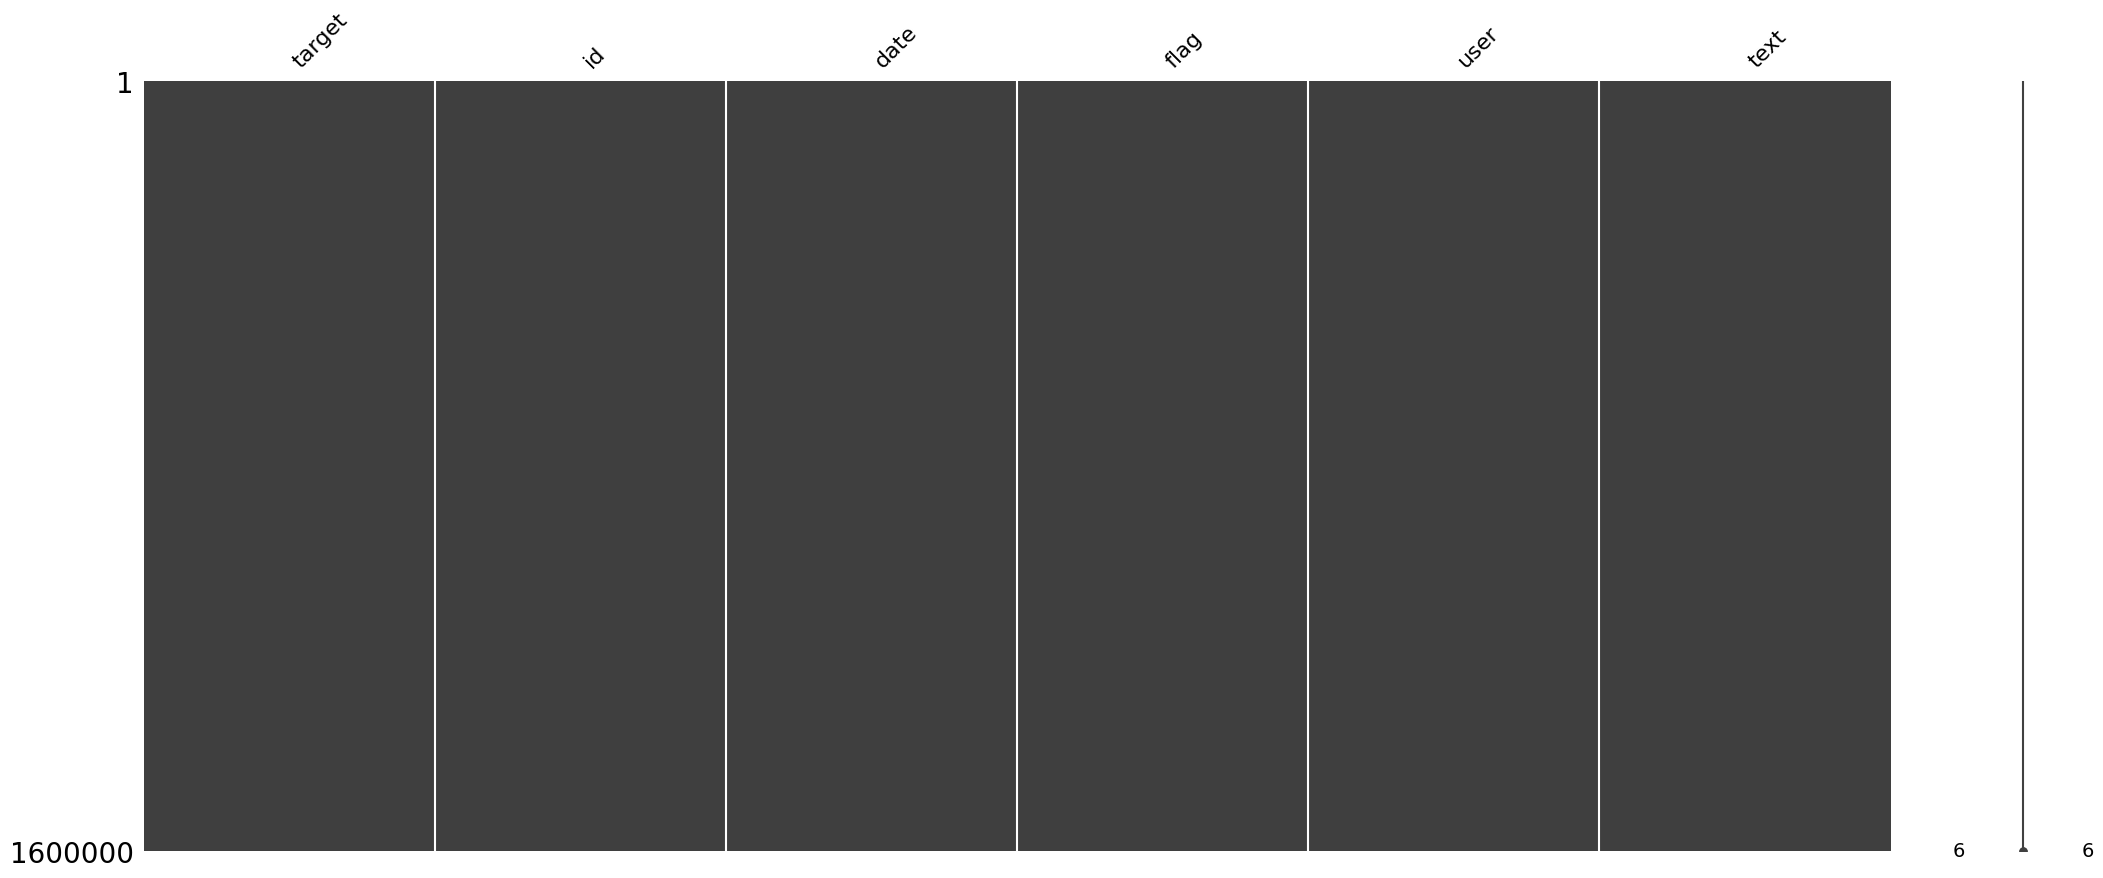

In [14]:
msno.matrix(data)

### Target

In [15]:
# Observation des valeurs de la colonne Target
unique_values = data["target"].unique()
print(unique_values)

[0 4]


In [16]:
# Répartition des valeurs
value_counts = data["target"].value_counts()
print(value_counts)

target
0    800000
4    800000
Name: count, dtype: int64


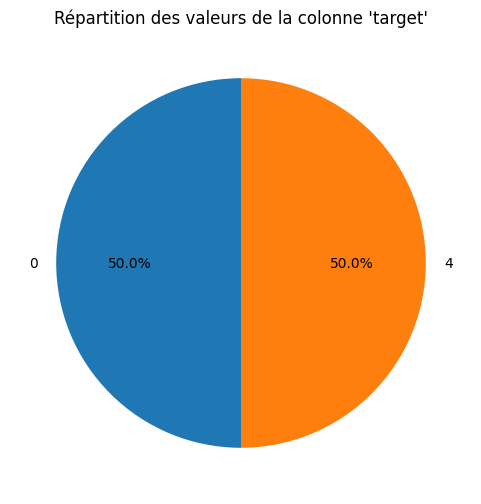

In [17]:
# Vue graphique
value_counts_graph = data["target"].value_counts()

value_counts_graph.plot(kind="pie", autopct="%1.1f%%", startangle=90, figsize=(6, 6))
plt.title("Répartition des valeurs de la colonne 'target'")
plt.ylabel("")
plt.show()

In [18]:
data.loc[data["target"] == 4, "target"] = 1
data.target.unique()

array([0, 1], dtype=int64)

### ID

In [19]:
print(data["id"].duplicated().sum())

1685


In [20]:
doublons = data[data["id"].duplicated()]
print(doublons)

         target          id                          date      flag  \
800261        1  1467863684  Mon Apr 06 22:33:35 PDT 2009  NO_QUERY   
800300        1  1467880442  Mon Apr 06 22:38:04 PDT 2009  NO_QUERY   
801280        1  1468053611  Mon Apr 06 23:28:09 PDT 2009  NO_QUERY   
801573        1  1468100580  Mon Apr 06 23:42:57 PDT 2009  NO_QUERY   
801650        1  1468115720  Mon Apr 06 23:48:00 PDT 2009  NO_QUERY   
...         ...         ...                           ...       ...   
1598780       1  2193278017  Tue Jun 16 08:14:22 PDT 2009  NO_QUERY   
1599298       1  2193403830  Tue Jun 16 08:24:44 PDT 2009  NO_QUERY   
1599385       1  2193428118  Tue Jun 16 08:26:44 PDT 2009  NO_QUERY   
1599440       1  2193451289  Tue Jun 16 08:28:37 PDT 2009  NO_QUERY   
1599931       1  2193576442  Tue Jun 16 08:38:45 PDT 2009  NO_QUERY   

                 user                                               text  
800261       DjGundam  Awwh babs... you look so sad underneith that s...

In [21]:
ids_dupliques = data["id"][data["id"].duplicated()]
print(ids_dupliques.unique())

[1467863684 1467880442 1468053611 ... 2193428118 2193451289 2193576442]


### Flag

In [22]:
unique_values = data["flag"].unique()
print(unique_values)

['NO_QUERY']


### Text

In [23]:
# Aperçu de la Target 0
ligne_target_0 = data[data["target"] == 0].iloc[799999]

print("Ligne avec target = 0 :")
print(ligne_target_0)


Ligne avec target = 0 :
target                                                    0
id                                               2329205794
date                           Thu Jun 25 10:28:31 PDT 2009
flag                                               NO_QUERY
user                                             tpchandler
text      has to resit exams over summer...  wishes he w...
Name: 799999, dtype: object


In [24]:
# Aperçu de la Target 4
ligne_target_1 = data[data["target"] == 1].iloc[0]

print("\nLigne avec target = 1 :")
print(ligne_target_1)


Ligne avec target = 1 :
target                                               1
id                                          1467822272
date                      Mon Apr 06 22:22:45 PDT 2009
flag                                          NO_QUERY
user                                             ersle
text      I LOVE @Health4UandPets u guys r the best!! 
Name: 800000, dtype: object


# Prétraitement

In [25]:
tweets_positifs = data[data["target"] == 1].sample(n=16000, random_state=77)

tweets_negatifs = data[data["target"] == 0].sample(n=16000, random_state=77)

df_tweets = pd.concat([tweets_positifs, tweets_negatifs])
df_tweets = df_tweets.reset_index(drop=True)
df_tweets

,target,id,date,flag,user,text
0,1,2175633751,Mon Jun 15 01:32:47 PDT 2009,NO_QUERY,Nessa2813,Listening/singing along to Taylor Swift while ...
1,1,1831959940,Sun May 17 19:51:47 PDT 2009,NO_QUERY,chopsoi,best sentence ever... &quot; i wish i'd been b...
2,1,1833823364,Mon May 18 00:35:05 PDT 2009,NO_QUERY,tigeladakawaii,Thanks @ttimechitchat ? http://blip.fm/~6im45
3,1,2015231983,Wed Jun 03 04:05:19 PDT 2009,NO_QUERY,dit53,"Good game so far , let's see what the second h..."
4,1,1678605865,Sat May 02 07:13:11 PDT 2009,NO_QUERY,binilvarghese,It's official now ! ! ! Scary yet feels good
...,...,...,...,...,...,...
31995,0,2213662162,Wed Jun 17 15:40:32 PDT 2009,NO_QUERY,MaxxAzria,my tummy hurts and i still have to do my h.w....
31996,0,2329173512,Thu Jun 25 10:26:13 PDT 2009,NO_QUERY,FirstLadyCfrank,"@houstonbeauty yea,not til September"
31997,0,2177497240,Mon Jun 15 06:12:37 PDT 2009,NO_QUERY,dohtay,Have to go to school today Need extra help in...
31998,0,2325621402,Thu Jun 25 05:47:01 PDT 2009,NO_QUERY,Shameez,My boys is never staying at home again.Last ti...


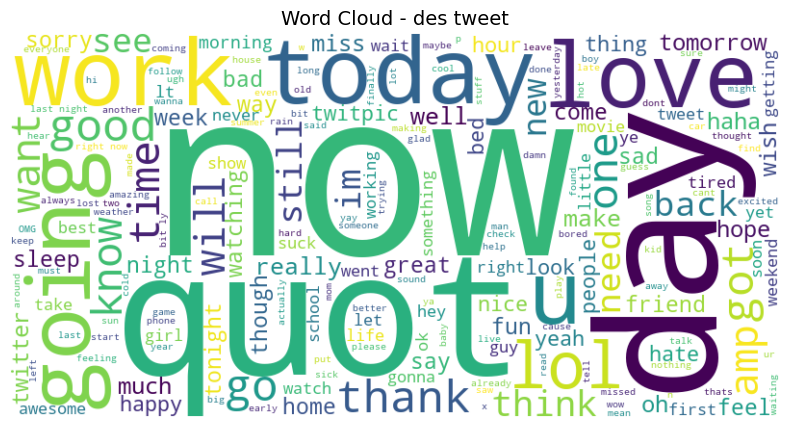

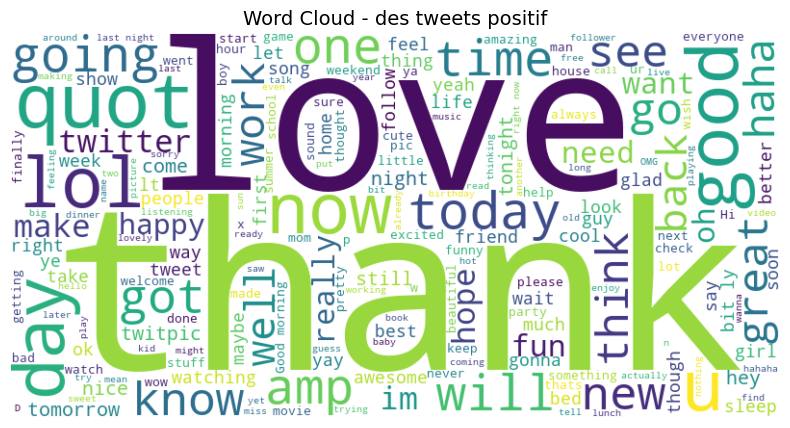

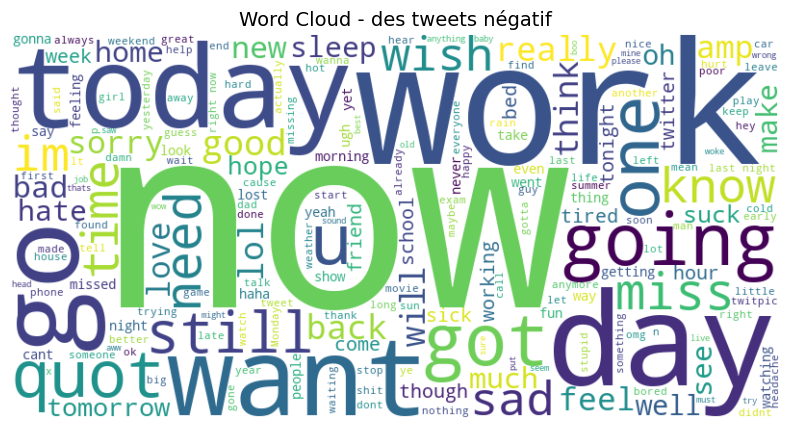

In [26]:
# Word cloud pour chaque type de sentiments
wordcloud(df_tweets["text"], "Word Cloud - des tweet")
wordcloud(tweets_positifs["text"], "Word Cloud - des tweets positif")
wordcloud(tweets_negatifs["text"], "Word Cloud - des tweets négatif")

In [27]:
df_tweets["clean_text"] = df_tweets["text"].apply(clean_text)
df_tweets

,target,id,date,flag,user,text,clean_text
0,1,2175633751,Mon Jun 15 01:32:47 PDT 2009,NO_QUERY,Nessa2813,Listening/singing along to Taylor Swift while ...,listening singing along taylor swift dishes
1,1,1831959940,Sun May 17 19:51:47 PDT 2009,NO_QUERY,chopsoi,best sentence ever... &quot; i wish i'd been b...,best sentence ever quot wish born pampered pan...
2,1,1833823364,Mon May 18 00:35:05 PDT 2009,NO_QUERY,tigeladakawaii,Thanks @ttimechitchat ? http://blip.fm/~6im45,thanks
3,1,2015231983,Wed Jun 03 04:05:19 PDT 2009,NO_QUERY,dit53,"Good game so far , let's see what the second h...",good game far let see second half brings
4,1,1678605865,Sat May 02 07:13:11 PDT 2009,NO_QUERY,binilvarghese,It's official now ! ! ! Scary yet feels good,official scary yet feels good
...,...,...,...,...,...,...,...
31995,0,2213662162,Wed Jun 17 15:40:32 PDT 2009,NO_QUERY,MaxxAzria,my tummy hurts and i still have to do my h.w....,tummy hurts still h w katy perry waking vegas ...
31996,0,2329173512,Thu Jun 25 10:26:13 PDT 2009,NO_QUERY,FirstLadyCfrank,"@houstonbeauty yea,not til September",yea til september
31997,0,2177497240,Mon Jun 15 06:12:37 PDT 2009,NO_QUERY,dohtay,Have to go to school today Need extra help in...,go school today need extra help french exam to...
31998,0,2325621402,Thu Jun 25 05:47:01 PDT 2009,NO_QUERY,Shameez,My boys is never staying at home again.Last ti...,boys never staying home last time internet mod...


In [28]:
"""vectorizer = TfidfVectorizer()

features = vectorizer.fit_transform(df_tweets["clean_text"])

features = features.toarray()

print("Dimenstion de la matrice :", features.shape)"""

'vectorizer = TfidfVectorizer()\n\nfeatures = vectorizer.fit_transform(df_tweets["clean_text"])\n\nfeatures = features.toarray()\n\nprint("Dimenstion de la matrice :", features.shape)'

In [29]:
"""X_train, X_temp, y_train, y_temp = train_test_split(features, df_tweets["target"], test_size = 0.2, stratify = df_tweets["target"], random_state=77)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=77)"""

'X_train, X_temp, y_train, y_temp = train_test_split(features, df_tweets["target"], test_size = 0.2, stratify = df_tweets["target"], random_state=77)\nX_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=77)'

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Découpage des données brutes
X_temp, X_test, y_temp, y_test = train_test_split(df_tweets["clean_text"], df_tweets["target"], test_size=0.2, stratify=df_tweets["target"], random_state=77)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=77)

# Transformation TF-IDF
vectorizer = TfidfVectorizer()

# Apprentissage du vocabulaire sur l'ensemble d'entraînement uniquement
X_train_vec = vectorizer.fit_transform(X_train)

# Transformation des ensembles de validation et de test avec le vocabulaire appris
X_val_vec = vectorizer.transform(X_val)
X_test_vec = vectorizer.transform(X_test)


## Modèles simple

### Regression Logistique

In [31]:
train_evaluate_simple_model("LinearRegression", LogisticRegression(), X_train_vec, y_train, X_val_vec, y_val)

2025/01/21 07:39:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LinearRegression at: http://127.0.0.1:5000/#/experiments/0/runs/a9846dce7bb0426a96217dddebf8ca15
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0


### RandomForest

In [32]:
train_evaluate_simple_model("RandomForest", RandomForestClassifier(), X_train_vec, y_train, X_val_vec, y_val)

2025/01/21 07:40:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForest at: http://127.0.0.1:5000/#/experiments/0/runs/0d54f0c334f244c3a74156a48d213242
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0


### XGBoost

In [33]:
train_evaluate_simple_model("XGBoost", XGBClassifier(), X_train_vec, y_train, X_val_vec, y_val)

2025/01/21 07:40:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run XGBoost at: http://127.0.0.1:5000/#/experiments/0/runs/2d323d9f465448ceaecb47511b79af4d
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0


## Modèle Avancé

### Préparation des données pour Glove

In [63]:
tokenizer = Tokenizer(num_words=50000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_val_seq = tokenizer.texts_to_sequences(X_val)
maxlen = max(len(x) for x in X_train_seq)
X_train_pad = pad_sequences(X_train_seq, maxlen=maxlen, padding="post", truncating="post")
X_test_pad = pad_sequences(X_test_seq, maxlen=maxlen, padding="post", truncating="post")
X_val_pad = pad_sequences(X_val_seq, maxlen=maxlen, padding="post", truncating="post")

# Charger l'embeddings de GloVe
embeddings_index = {}
with open("C:/Users/icema/OpenClassrooms/AI_Engineer/.venv7/glove.twitter.27B.200d.txt", encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype="float32")
        embeddings_index[word] = coefs

# Préparer la matrice d'embedding
embedding_matrix = np.zeros((50000, 200)) # 200 Dimension des vecteurs Glove (25, 50 et 100 possible)
for word, i in tokenizer.word_index.items():
    if i < 32000:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

#### Glove

Epoch 1/50
1599/1600 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6842 - loss: 0.5823
Epoch 1: val_loss improved from inf to 0.50347, saving model to model_best_weights.keras
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 54s 33ms/step - accuracy: 0.6842 - loss: 0.5823 - val_accuracy: 0.7678 - val_loss: 0.5035
Epoch 2/50
1599/1600 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7687 - loss: 0.4786
Epoch 2: val_loss improved from 0.50347 to 0.48524, saving model to model_best_weights.keras
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 52s 32ms/step - accuracy: 0.7687 - loss: 0.4786 - val_accuracy: 0.7781 - val_loss: 0.4852
Epoch 3/50
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7896 - loss: 0.4472
Epoch 3: val_loss improved from 0.48524 to 0.47562, saving model to model_best_weights.keras
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 52s 33ms/step - accuracy: 0.7896 - loss: 0.4472 - val_accuracy: 0.7834 - val_loss: 0.4756
Epoch 4/50
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8028 - loss: 0.4258
Epoch 

2025/01/21 11:29:15 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Validation Accuracy :  0.7895


2025/01/21 11:29:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


3200/3200 ━━━━━━━━━━━━━━━━━━━━ 2s 476us/step
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step

Test Metrics:
Accuracy: 0.7692187428474426
Recall: 0.7853125
F1 Score: 0.7852431601756183
AUC: 0.8692117431640625
Specificity: 0.76734375
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 486us/step

Validation Metrics:
Accuracy: 0.7895312309265137
Recall: 0.78953125
F1 Score: 0.7895108537250595
AUC: 0.8718113525390624
Specificity: 0.7796875


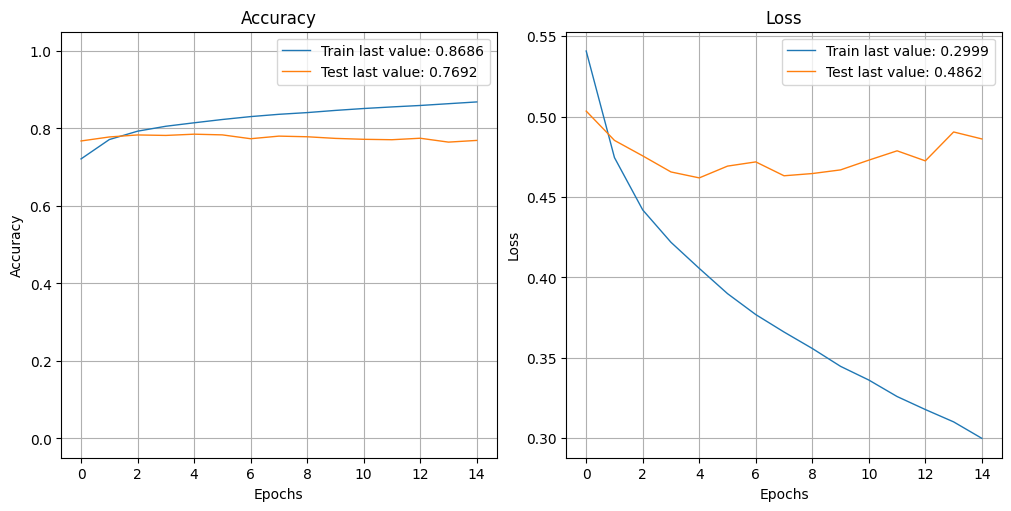

🏃 View run GloVe at: http://127.0.0.1:5000/#/experiments/2/runs/f1440c291526454cb4a2439c8b14aaa5
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


In [68]:
embedding_layer = Embedding(input_dim=50000, output_dim=200, trainable=True)
embedding_layer.build((None,))
embedding_layer.set_weights([embedding_matrix])

model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.4))
model.add(GlobalMaxPooling1D())
model.add(Dense(256, activation="relu"))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss="binary_crossentropy", optimizer="Adam", metrics=["accuracy"])

# Exécution de la fonction avec nos données
train_evaluate_neural_model("Neurones", "GloVe", model, X_train_pad, y_train, X_test_pad, y_test, X_val_pad, y_val)

#### Glove + LSTM

Epoch 1/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6850 - loss: 0.5831
Epoch 1: val_loss improved from inf to 0.49055, saving model to model_best_weights.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 13s 40ms/step - accuracy: 0.6852 - loss: 0.5829 - val_accuracy: 0.7544 - val_loss: 0.4906
Epoch 2/50
299/300 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8039 - loss: 0.4280
Epoch 2: val_loss did not improve from 0.49055
300/300 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - accuracy: 0.8039 - loss: 0.4281 - val_accuracy: 0.7445 - val_loss: 0.5187
Epoch 3/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8528 - loss: 0.3396
Epoch 3: val_loss did not improve from 0.49055
300/300 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - accuracy: 0.8528 - loss: 0.3396 - val_accuracy: 0.7498 - val_loss: 0.5491
Epoch 4/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8974 - loss: 0.2498
Epoch 4: val_loss did not improve from 0.49055
300/300 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - accuracy: 0.8974 - l

2025/01/21 07:44:30 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Validation Accuracy :  0.7620


2025/01/21 07:44:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


600/600 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

Test Metrics:
Accuracy: 0.696093738079071
Recall: 0.754375
F1 Score: 0.7530883346312754
AUC: 0.8459528808593749
Specificity: 0.6821875
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

Validation Metrics:
Accuracy: 0.7620312571525574
Recall: 0.76203125
F1 Score: 0.7610839326272965
AUC: 0.847780419921875
Specificity: 0.6990625


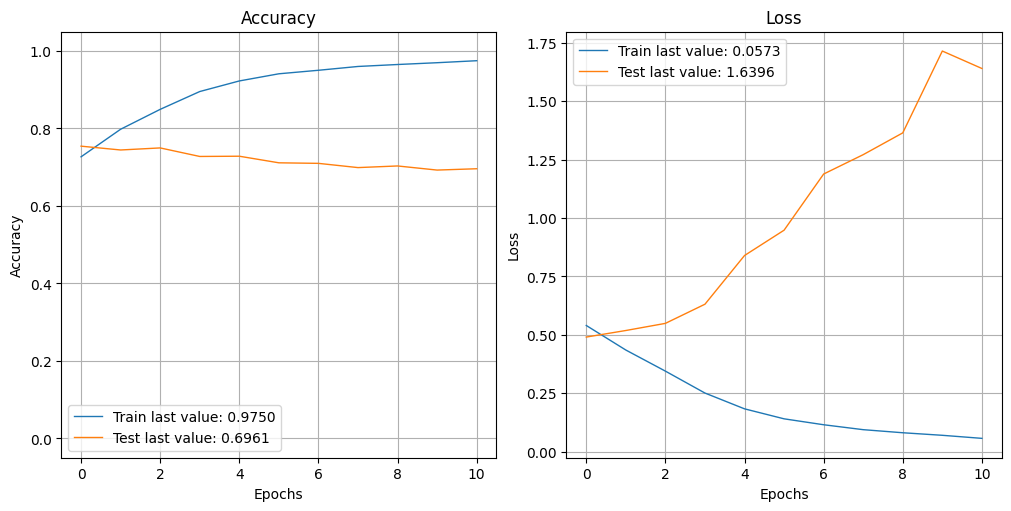

🏃 View run GloVe_LSTM at: http://127.0.0.1:5000/#/experiments/2/runs/9666187c92f34632bfee705ce1a1c357
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


In [36]:
embedding_layer = Embedding(input_dim=32000, output_dim=200, trainable=True)
embedding_layer.build((None,))
embedding_layer.set_weights([embedding_matrix])

model = Sequential()
model.add(embedding_layer)
model.add(Bidirectional(LSTM(128)))
model.add(Dropout(0.4))
model.add(Dense(16, activation="relu"))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])


# Exécution de la fonction avec nos données
train_evaluate_neural_model("Neurones", "GloVe_LSTM", model, X_train_pad, y_train, X_test_pad, y_test, X_val_pad, y_val)

#### Glove + GRU

Epoch 1/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6814 - loss: 0.5844
Epoch 1: val_loss improved from inf to 0.48965, saving model to model_best_weights.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 13s 39ms/step - accuracy: 0.6815 - loss: 0.5843 - val_accuracy: 0.7606 - val_loss: 0.4897
Epoch 2/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8034 - loss: 0.4306
Epoch 2: val_loss did not improve from 0.48965
300/300 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - accuracy: 0.8034 - loss: 0.4306 - val_accuracy: 0.7636 - val_loss: 0.4914
Epoch 3/50
299/300 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8612 - loss: 0.3263
Epoch 3: val_loss did not improve from 0.48965
300/300 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.8611 - loss: 0.3264 - val_accuracy: 0.7459 - val_loss: 0.5335
Epoch 4/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9065 - loss: 0.2296
Epoch 4: val_loss did not improve from 0.48965
300/300 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9065 - l

2025/01/21 07:47:13 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Validation Accuracy :  0.7667


2025/01/21 07:47:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


600/600 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

Test Metrics:
Accuracy: 0.6964062452316284
Recall: 0.760625
F1 Score: 0.7601392820461434
AUC: 0.843425341796875
Specificity: 0.715625
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

Validation Metrics:
Accuracy: 0.7667187452316284
Recall: 0.76671875
F1 Score: 0.7662935080288057
AUC: 0.8502898437499999
Specificity: 0.7240625


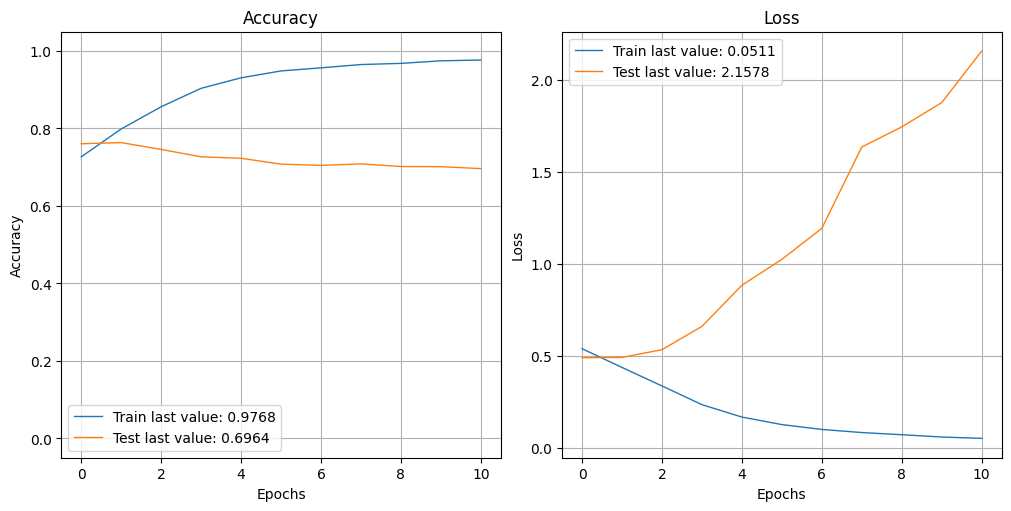

🏃 View run GloVe_GRU at: http://127.0.0.1:5000/#/experiments/2/runs/11c453453e4e48b2a81f186d53933263
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


In [37]:
embedding_layer = Embedding(input_dim=32000, output_dim=200, trainable=True)
embedding_layer.build((None,))
embedding_layer.set_weights([embedding_matrix])

model = Sequential()
model.add(embedding_layer)
model.add(Bidirectional(GRU(128)))
model.add(Dropout(0.4))
model.add(Dense(128, activation="relu"))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])


# Exécution de la fonction avec nos données
train_evaluate_neural_model("Neurones", "GloVe_GRU", model, X_train_pad, y_train, X_test_pad, y_test, X_val_pad, y_val)

### Préparation des données pour FastText

In [38]:
# Charger les vecteurs FastText
fasttext_path = "C:/Users/icema/OpenClassrooms/AI_Engineer/.venv7/cc.en.300.vec"
fasttext_model = KeyedVectors.load_word2vec_format(fasttext_path, binary=False)

# Préparer l'index des embeddings
embeddings_index = {}
for word in fasttext_model.index_to_key:
    embeddings_index[word] = fasttext_model[word]

In [39]:
# Préparation de l'embedding
embedding_dim = 300  # Dimension des vecteurs FastText
embedding_matrix = np.zeros((32000, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < 32000:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

#### FastText

Epoch 1/50
299/300 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6289 - loss: 0.6415
Epoch 1: val_loss improved from inf to 0.53675, saving model to model_best_weights.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.6292 - loss: 0.6412 - val_accuracy: 0.7316 - val_loss: 0.5368
Epoch 2/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7819 - loss: 0.4684
Epoch 2: val_loss improved from 0.53675 to 0.52373, saving model to model_best_weights.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.7819 - loss: 0.4684 - val_accuracy: 0.7372 - val_loss: 0.5237
Epoch 3/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8352 - loss: 0.3797
Epoch 3: val_loss did not improve from 0.52373
300/300 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.8352 - loss: 0.3797 - val_accuracy: 0.7359 - val_loss: 0.5281
Epoch 4/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8728 - loss: 0.3083
Epoch 4: val_loss did not improve from 0.52373
300/300 ━━━━━━━━━━━━━━

2025/01/21 07:51:57 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Validation Accuracy :  0.7364


2025/01/21 07:52:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 507us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 513us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 593us/step

Test Metrics:
Accuracy: 0.6951562762260437
Recall: 0.7371875
F1 Score: 0.7363346042412978
AUC: 0.82094833984375
Specificity: 0.7940625
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step

Validation Metrics:
Accuracy: 0.7364062666893005
Recall: 0.73640625
F1 Score: 0.735367353658095
AUC: 0.821165283203125
Specificity: 0.7990625


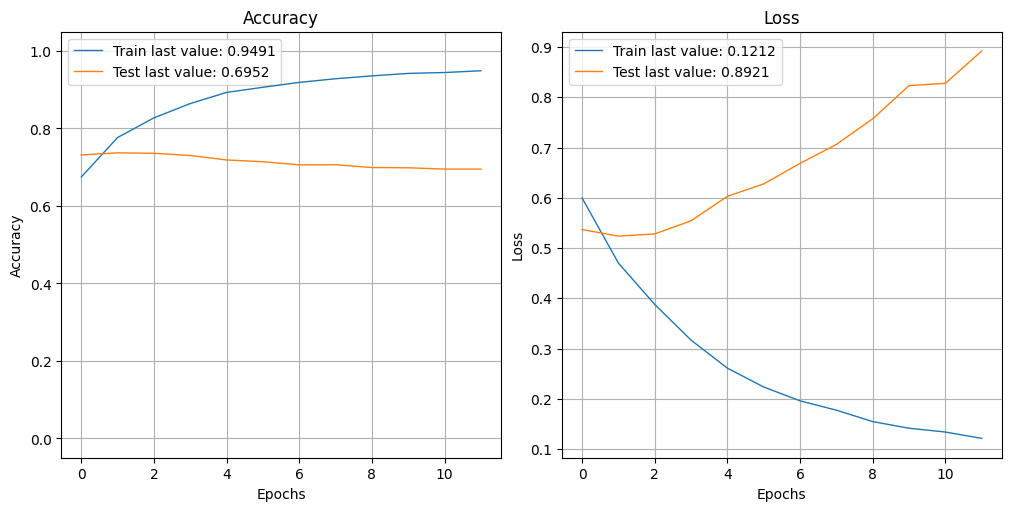

🏃 View run FastText at: http://127.0.0.1:5000/#/experiments/2/runs/d4fbffb4c19f4234b10375e90ab3e9a0
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


In [40]:
embedding_layer = Embedding(input_dim=32000, output_dim=embedding_dim, trainable=True)
embedding_layer.build((None,))
embedding_layer.set_weights([embedding_matrix])

model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.4))
model.add(GlobalMaxPooling1D())
model.add(Dense(256, activation="relu"))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Exécution de la fonction avec nos données
train_evaluate_neural_model("Neurones", "FastText", model, X_train_pad, y_train, X_test_pad, y_test, X_val_pad, y_val)

#### FastText + LSTM

Epoch 1/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.6596 - loss: 0.6106
Epoch 1: val_loss improved from inf to 0.51073, saving model to model_best_weights.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 30s 95ms/step - accuracy: 0.6598 - loss: 0.6104 - val_accuracy: 0.7525 - val_loss: 0.5107
Epoch 2/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.8255 - loss: 0.4022
Epoch 2: val_loss did not improve from 0.51073
300/300 ━━━━━━━━━━━━━━━━━━━━ 26s 86ms/step - accuracy: 0.8255 - loss: 0.4022 - val_accuracy: 0.7420 - val_loss: 0.5442
Epoch 3/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.8827 - loss: 0.2778
Epoch 3: val_loss did not improve from 0.51073
300/300 ━━━━━━━━━━━━━━━━━━━━ 26s 86ms/step - accuracy: 0.8827 - loss: 0.2778 - val_accuracy: 0.7230 - val_loss: 0.6621
Epoch 4/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.9238 - loss: 0.1882
Epoch 4: val_loss did not improve from 0.51073
300/300 ━━━━━━━━━━━━━━━━━━━━ 25s 85ms/step - accuracy: 0.9238 - l

2025/01/21 07:57:09 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Validation Accuracy :  0.7445


2025/01/21 07:57:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


600/600 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step

Test Metrics:
Accuracy: 0.6931250095367432
Recall: 0.7525
F1 Score: 0.7521964406397837
AUC: 0.8314230468749999
Specificity: 0.7875
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step

Validation Metrics:
Accuracy: 0.7445312738418579
Recall: 0.74453125
F1 Score: 0.744143961664237
AUC: 0.8311693359375001
Specificity: 0.7834375


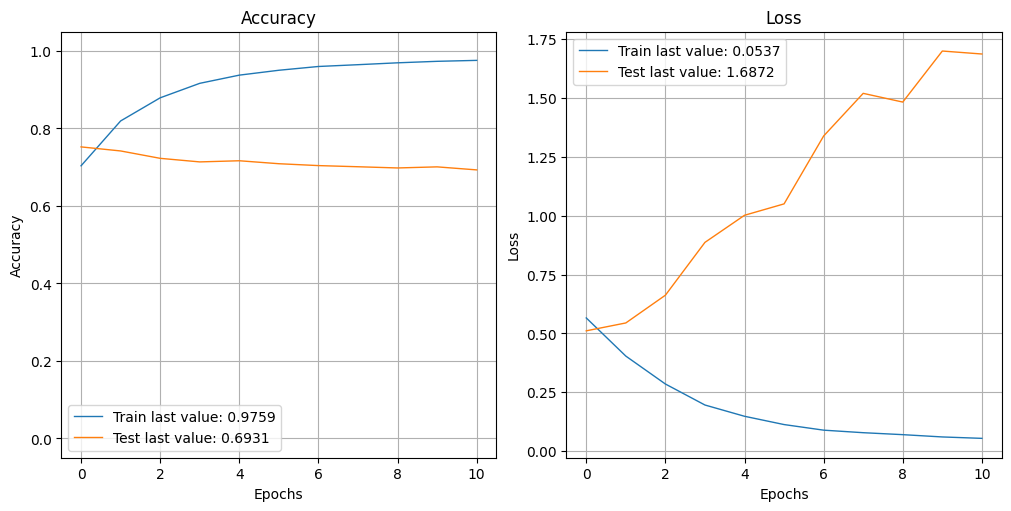

🏃 View run FastText_LSTM at: http://127.0.0.1:5000/#/experiments/2/runs/a17886d5971a46df92348e42669fd4eb
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


In [41]:
embedding_layer = Embedding(input_dim=32000, output_dim=300, trainable=True)
embedding_layer.build((None,))
embedding_layer.set_weights([embedding_matrix])

model = Sequential()
model.add(embedding_layer)
model.add(Bidirectional(LSTM(128)))
model.add(Dropout(0.4))
model.add(Dense(16, activation="relu"))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Exécution de la fonction avec nos données
train_evaluate_neural_model("Neurones", "FastText_LSTM", model, X_train_pad, y_train, X_test_pad, y_test, X_val_pad, y_val)

#### FastText + GRU

Epoch 1/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.6531 - loss: 0.6148
Epoch 1: val_loss improved from inf to 0.50620, saving model to model_best_weights.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 31s 99ms/step - accuracy: 0.6532 - loss: 0.6146 - val_accuracy: 0.7503 - val_loss: 0.5062
Epoch 2/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.8255 - loss: 0.3987
Epoch 2: val_loss did not improve from 0.50620
300/300 ━━━━━━━━━━━━━━━━━━━━ 26s 88ms/step - accuracy: 0.8255 - loss: 0.3987 - val_accuracy: 0.7377 - val_loss: 0.5425
Epoch 3/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.8930 - loss: 0.2547
Epoch 3: val_loss did not improve from 0.50620
300/300 ━━━━━━━━━━━━━━━━━━━━ 27s 89ms/step - accuracy: 0.8929 - loss: 0.2548 - val_accuracy: 0.7266 - val_loss: 0.7211
Epoch 4/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.9367 - loss: 0.1582
Epoch 4: val_loss did not improve from 0.50620
300/300 ━━━━━━━━━━━━━━━━━━━━ 27s 90ms/step - accuracy: 0.9367 - l

2025/01/21 08:02:55 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Validation Accuracy :  0.7561


2025/01/21 08:03:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


600/600 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step

Test Metrics:
Accuracy: 0.7001562714576721
Recall: 0.7503125
F1 Score: 0.7503036972299512
AUC: 0.8293060058593751
Specificity: 0.744375
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step

Validation Metrics:
Accuracy: 0.7560937404632568
Recall: 0.75609375
F1 Score: 0.7560936011313484
AUC: 0.8373931640625
Specificity: 0.7553125


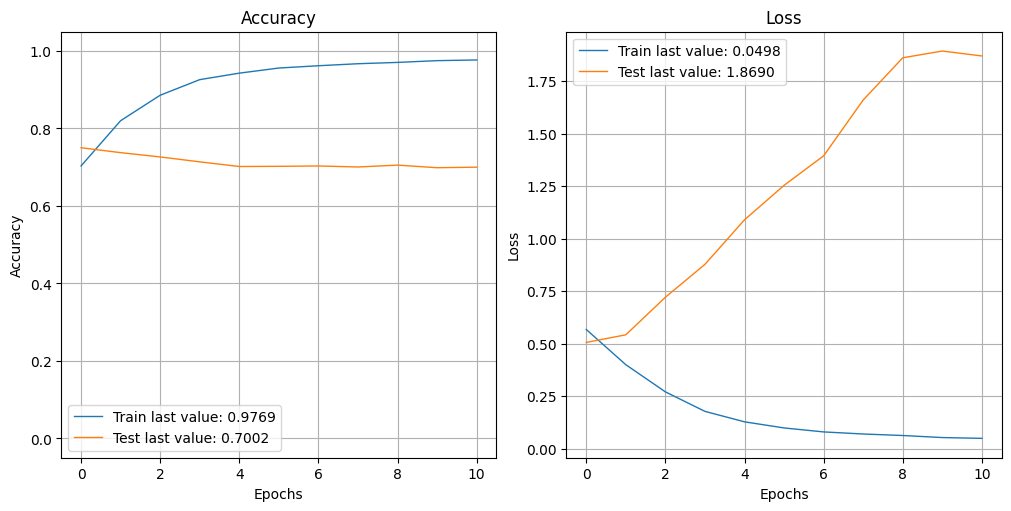

🏃 View run FastText_GRU at: http://127.0.0.1:5000/#/experiments/2/runs/8461a16737684a14b81b8869c1bf040c
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


In [42]:
embedding_layer = Embedding(input_dim=32000, output_dim=300, trainable=True)
embedding_layer.build((None,))
embedding_layer.set_weights([embedding_matrix])

model = Sequential()
model.add(embedding_layer)
model.add(Bidirectional(GRU(128)))
model.add(Dropout(0.4))
model.add(Dense(128, activation="relu"))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Exécution de la fonction avec nos données
train_evaluate_neural_model("Neurones", "FastText_GRU", model, X_train_pad, y_train, X_test_pad, y_test, X_val_pad, y_val)

### Préparation des données pour USE

In [43]:
use_model = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

X_train_embeddings = use_model(X_train)
X_test_embeddings = use_model(X_test)
X_val_embeddings = use_model(X_val)

#### USE

Epoch 1/50


c:\Users\icema\OpenClassrooms\AI_Engineer\.venv7\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


294/300 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6811 - loss: 0.5953
Epoch 1: val_loss improved from inf to 0.51844, saving model to model_best_weights.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6820 - loss: 0.5943 - val_accuracy: 0.7444 - val_loss: 0.5184
Epoch 2/50
274/300 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7428 - loss: 0.5218
Epoch 2: val_loss improved from 0.51844 to 0.51338, saving model to model_best_weights.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7432 - loss: 0.5211 - val_accuracy: 0.7461 - val_loss: 0.5134
Epoch 3/50
275/300 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7620 - loss: 0.4942
Epoch 3: val_loss did not improve from 0.51338
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7618 - loss: 0.4943 - val_accuracy: 0.7495 - val_loss: 0.5165
Epoch 4/50
274/300 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7730 - loss: 0.4793
Epoch 4: val_loss improved from 0.51338 to 0.50974, saving model to model_best_weights.

2025/01/21 08:03:32 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


2025/01/21 08:03:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 531us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 498us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step

Test Metrics:
Accuracy: 0.7284374833106995
Recall: 0.745
F1 Score: 0.7448070103015405
AUC: 0.829767919921875
Specificity: 0.7725
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step

Validation Metrics:
Accuracy: 0.7503125071525574
Recall: 0.7503125
F1 Score: 0.7501824924318524
AUC: 0.8326382324218751
Specificity: 0.773125


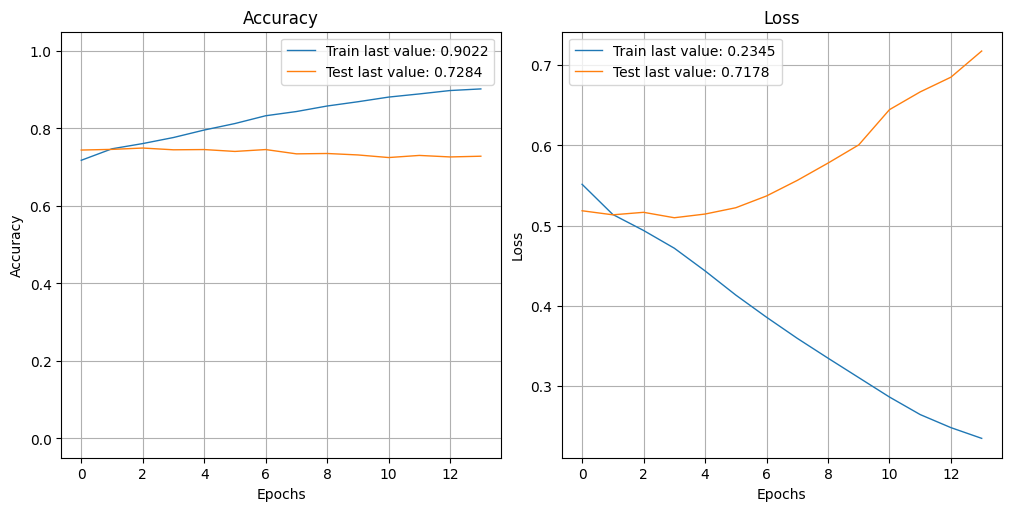

🏃 View run USE at: http://127.0.0.1:5000/#/experiments/2/runs/e4d636629d3f4287826dd5ff1e214311
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


In [44]:
model = Sequential()
model.add(Dense(256, activation="relu", input_shape=(512,)))
model.add(Dropout(0.4))
model.add(Dense(32, activation="relu"))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

train_evaluate_neural_model("Neurones", "USE", model, X_train_embeddings, y_train, X_test_embeddings, y_test, X_val_embeddings, y_val)

* USE diffère des embeddings classiques comme GloVe ou FastText.
* Contrairement à eux qui génèrent des vecteurs mot par mot, USE génère un vecteur d'encodage pour des phrases ou des textes entiers.
* Cela simplifie l'architecture du modèle et élimine la nécessité d'utiliser une couche d'embedding.

## BERT

In [45]:
max_length = 64
batch_size = 10
model_type = "bert-base-uncased"
model = TFAutoModel.from_pretrained(model_type)
sentences = df_tweets["clean_text"].to_list()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [46]:
# Création des features
features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences,
                                                        max_length, batch_size, mode="HF")

1/1 [==============================] - 0s 199ms/step
temps traitement :  2453.0


In [47]:
# Utilisation des features de BERT
X_train_bert = features_bert[y_train.index]
X_test_bert = features_bert[y_test.index]
X_val_bert = features_bert[y_val.index]

#### BERT + LSTM

Epoch 1/50


c:\Users\icema\OpenClassrooms\AI_Engineer\.venv7\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6619 - loss: 0.6073
Epoch 1: val_loss improved from inf to 0.55004, saving model to model_best_weights.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6620 - loss: 0.6072 - val_accuracy: 0.7173 - val_loss: 0.5500
Epoch 2/50
275/300 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7256 - loss: 0.5427
Epoch 2: val_loss improved from 0.55004 to 0.54254, saving model to model_best_weights.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7255 - loss: 0.5427 - val_accuracy: 0.7202 - val_loss: 0.5425
Epoch 3/50
286/300 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7397 - loss: 0.5261
Epoch 3: val_loss improved from 0.54254 to 0.53646, saving model to model_best_weights.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7396 - loss: 0.5263 - val_accuracy: 0.7277 - val_loss: 0.5365
Epoch 4/50
298/300 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7484 - loss: 0.5130
Epoch 4: val_loss did not improve from 0.

2025/01/21 08:44:44 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Validation Accuracy :  0.73


2025/01/21 08:44:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 608us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 583us/step

Test Metrics:
Accuracy: 0.7056249976158142
Recall: 0.72765625
F1 Score: 0.7271074735226216
AUC: 0.80572265625
Specificity: 0.7725
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 623us/step

Validation Metrics:
Accuracy: 0.7262499928474426
Recall: 0.72625
F1 Score: 0.7256062196706629
AUC: 0.8053560546875
Specificity: 0.7746875


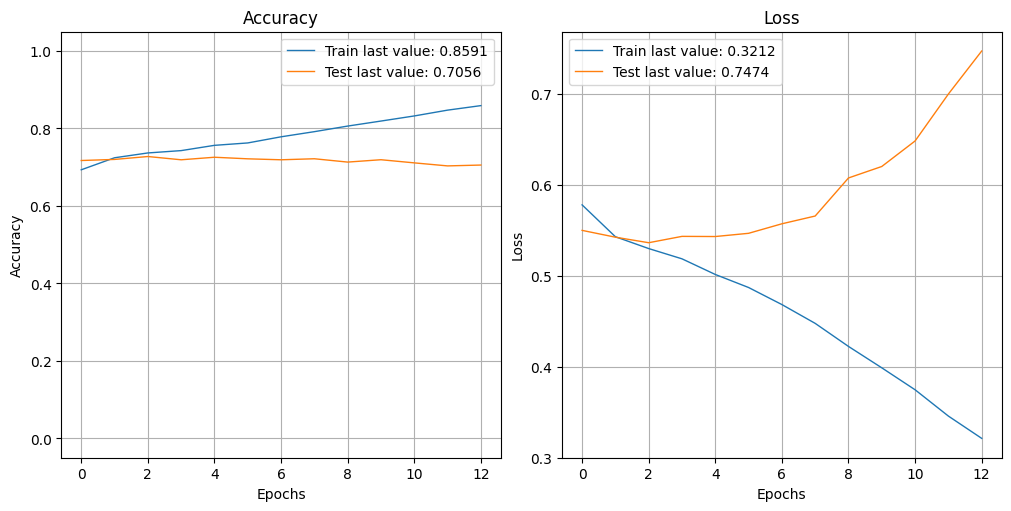

🏃 View run BERT_LSDM at: http://127.0.0.1:5000/#/experiments/2/runs/45ef952b33e54a88985f5d3b4b0ce6f8
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


In [48]:
input_dim = X_train_bert.shape[1]
model = Sequential()
model.add(Dense(128, activation="relu", input_dim=input_dim))
model.add(Reshape((1, 128)))
model.add(Bidirectional(LSTM(128)))
model.add(Dropout(0.4))
model.add(Dense(16, activation="relu"))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Appel de la fonction avec le modèle et les données
train_evaluate_BERT_model("Neurones", "BERT_LSDM", model, X_train_bert, y_train, X_test_bert, y_test, X_val_bert, y_val)

#### BERT + GRU

Epoch 1/50


c:\Users\icema\OpenClassrooms\AI_Engineer\.venv7\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


268/300 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6490 - loss: 0.6113
Epoch 1: val_loss improved from inf to 0.54191, saving model to model_best_weights.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6536 - loss: 0.6078 - val_accuracy: 0.7247 - val_loss: 0.5419
Epoch 2/50
298/300 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7181 - loss: 0.5494
Epoch 2: val_loss did not improve from 0.54191
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7181 - loss: 0.5493 - val_accuracy: 0.7234 - val_loss: 0.5421
Epoch 3/50
293/300 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7367 - loss: 0.5276
Epoch 3: val_loss did not improve from 0.54191
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7366 - loss: 0.5276 - val_accuracy: 0.7166 - val_loss: 0.5430
Epoch 4/50
281/300 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7470 - loss: 0.5129
Epoch 4: val_loss did not improve from 0.54191
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7469 - loss: 0.5130 - val_accur

2025/01/21 08:45:02 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Validation Accuracy :  0.72


2025/01/21 08:45:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 618us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 671us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step

Test Metrics:
Accuracy: 0.7056249976158142
Recall: 0.7246875
F1 Score: 0.7246836283635238
AUC: 0.798709619140625
Specificity: 0.7284375
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 656us/step

Validation Metrics:
Accuracy: 0.7223437428474426
Recall: 0.72234375
F1 Score: 0.7223432009228339
AUC: 0.79892490234375
Specificity: 0.7209375


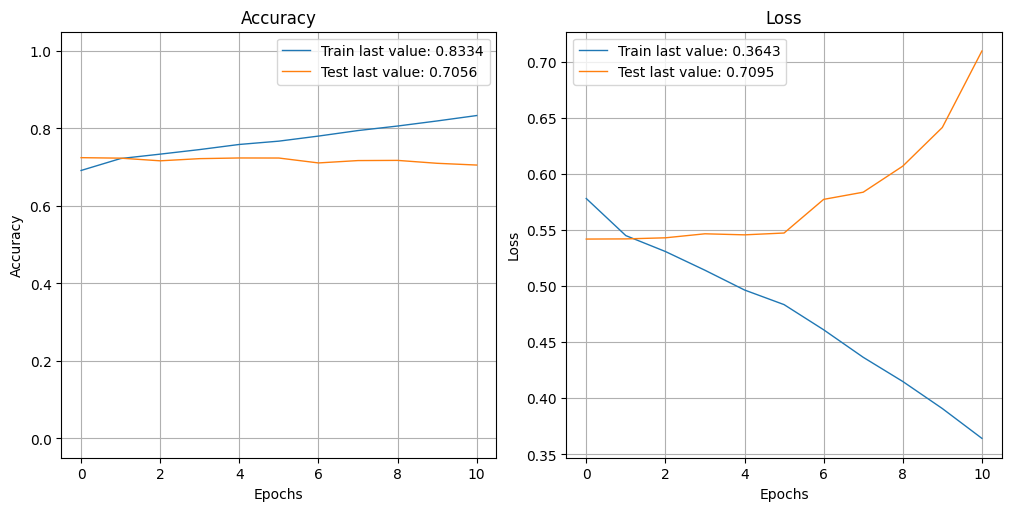

🏃 View run BERT_GRU at: http://127.0.0.1:5000/#/experiments/2/runs/e19b872351c04907a97b8eaf254d765f
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


In [49]:
model = Sequential()
model.add(Dense(128, activation="relu", input_dim=input_dim))
model.add(Reshape((1, 128)))
model.add(Bidirectional(GRU(128)))
model.add(Dropout(0.4))
model.add(Dense(128, activation="relu"))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Appel de la fonction avec le modèle et les données
train_evaluate_BERT_model("Neurones", "BERT_GRU", model, X_train_bert, y_train, X_test_bert, y_test, X_val_bert, y_val)

# Test sur 128 000 tweets

## FastText + GRU

In [ ]:
# Échantillonnage équilibré
df_positifs = data[data["target"] == 1].sample(n=64000, random_state=77)
df_negatifs = data[data["target"] == 0].sample(n=64000, random_state=77)

# Concaténation et mélange des données
df_model = pd.concat([df_positifs, df_negatifs]).sample(frac=1, random_state=77).reset_index(drop=True)

# Nettoyage des textes avec un pipeline avancé
df_model["clean_text"] = df_model["text"].apply(lambda x: process_text(x,
                                                                    rejoin=True,
                                                                    lemm_or_stemm="lem",
                                                                    force_is_alpha=True,
                                                                    include_stopwords=True))

# Séparation des données (entraînement, validation, test)
X_train, X_temp, y_train, y_temp = train_test_split(df_model["clean_text"], df_model["target"], test_size=0.2, stratify=df_model["target"], random_state=77)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=77)

# Préparation des données avec un tokenizer
vocab_size = 50000
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding des séquences
max_len = max(len(seq) for seq in X_train_seq)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding="post", truncating="post")
X_val_pad = pad_sequences(X_val_seq, maxlen=max_len, padding="post", truncating="post")
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding="post", truncating="post")

# Chargement et création des embeddings FastText
ft = fasttext.load_model("C:/Users/icema/OpenClassrooms/AI_Engineer/.venv7/cc.en.300.bin")

embedding_dim = ft.get_dimension()
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, index in tokenizer.word_index.items():
    if index < vocab_size:
        embedding_vector = ft[word] if word in ft else None
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

# Construction du modèle avec GRU bidirectionnel
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=True),
    Bidirectional(GRU(128, return_sequences=False)),
    Dropout(0.5),
    Dense(32, activation="relu"),
    Dropout(0.5),
    Dense(1, activation="sigmoid")
])

# Compilation du modèle
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

# Enregistrement avec MLflow
with mlflow.start_run(run_name="FastText + GRU Model"):
    # Enregistrement des hyperparamètres
    mlflow.log_param("vocab_size", vocab_size)
    mlflow.log_param("max_len", max_len)
    mlflow.log_param("embedding_dim", embedding_dim)
    mlflow.log_param("gru_units", 128)
    mlflow.log_param("dropout_rate", 0.5)
    mlflow.log_param("batch_size", 64)
    mlflow.log_param("epochs", 10)
    mlflow.log_param("optimizer", "adam")
    mlflow.log_param("loss", "binary_crossentropy")

    # Entraînement avec EarlyStopping
    history = model.fit(
        X_train_pad, y_train,
        validation_data=(X_val_pad, y_val),
        epochs=10,
        batch_size=64,
        callbacks=[EarlyStopping(patience=3, restore_best_weights=True)]
    )

    # Évaluation sur l'ensemble de test
    y_pred_prob = model.predict(X_test_pad, batch_size=64)
    y_pred = (y_pred_prob > 0.5).astype("int32")

    test_loss, test_accuracy = model.evaluate(X_test_pad, y_test, batch_size=64)
    auc = roc_auc_score(y_test, y_pred_prob)
    conf_matrix = confusion_matrix(y_test, y_pred)
    classification_rep = classification_report(y_test, y_pred, target_names=["Negative", "Positive"])

    # Enregistrement des métriques
    mlflow.log_metric("test_loss", test_loss)
    mlflow.log_metric("test_accuracy", test_accuracy)
    mlflow.log_metric("auc", auc)

    # Enregistrement de la matrice de confusion
    np.save("confusion_matrix.npy", conf_matrix)
    mlflow.log_artifact("confusion_matrix.npy")

    # Enregistrement du modèle
    mlflow.keras.log_model(model, artifact_path="models")

    # Résultats dans la console
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, AUC: {auc:.4f}")
    print("\nConfusion Matrix:")
    print(conf_matrix)
    print("\nClassification Report:")
    print(classification_rep)

c:\Users\icema\OpenClassrooms\AI_Engineer\.venv7\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_16 (Embedding)        │ ?                      │    15,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_8 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,000,000 (57.22 MB)

 Trainable params: 15,000,000 (57.22 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 251s 156ms/step - accuracy: 0.7222 - loss: 0.5415 - val_accuracy: 0.8044 - val_loss: 0.4279
Epoch 2/10
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 182s 114ms/step - accuracy: 0.8427 - loss: 0.3665 - val_accuracy: 0.7960 - val_loss: 0.4390
Epoch 3/10
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 219s 137ms/step - accuracy: 0.8938 - loss: 0.2617 - val_accuracy: 0.7877 - val_loss: 0.5041
Epoch 4/10
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 187s 117ms/step - accuracy: 0.9238 - loss: 0.1905 - val_accuracy: 0.7855 - val_loss: 0.6265
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.7988 - loss: 0.4278


2025/01/21 11:53:07 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/01/21 11:53:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Test Loss: 0.4332, Test Accuracy: 0.7965, AUC: 0.8816

Confusion Matrix:
[[5203 1197]
 [1408 4992]]

Classification Report:
              precision    recall  f1-score   support

    Negative       0.79      0.81      0.80      6400
    Positive       0.81      0.78      0.79      6400

    accuracy                           0.80     12800
   macro avg       0.80      0.80      0.80     12800
weighted avg       0.80      0.80      0.80     12800

🏃 View run FastText + GRU Model at: http://127.0.0.1:5000/#/experiments/2/runs/f180da24034a4d4b967ba80c3253cde2
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


In [51]:
# Sauvegarde du modèle
model_path = "FastText_gru_model.keras"
model.save(model_path)

## Glove + GRU

In [70]:
# Chemin du fichier GloVe
glove_file = "C:/Users/icema/OpenClassrooms/AI_Engineer/.venv7/glove.twitter.27B.200d.txt"

# Chargement des embeddings GloVe
embedding_index = {}
with open(glove_file, "r", encoding="utf-8") as file:
    for line in file:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype="float32")
        embedding_index[word] = coefs

# Création de la matrice d'embedding
embedding_dim = 200  # Les dimensions de GloVe (par exemple, 200d)
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, index in tokenizer.word_index.items():
    if index < vocab_size:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

In [ ]:
# Construction du modèle avec GRU bidirectionnel et GloVe
model = Sequential([
    Embedding(input_dim=vocab_size,
            output_dim=embedding_dim,
            weights=[embedding_matrix],
            input_length=max_len,
            trainable=False),
    Bidirectional(GRU(128, return_sequences=False)),
    Dropout(0.5),
    Dense(32, activation="relu"),
    Dropout(0.5),
    Dense(1, activation="sigmoid")
])

# Compilation du modèle
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

c:\Users\icema\OpenClassrooms\AI_Engineer\.venv7\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_17 (Embedding)        │ ?                      │    10,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_9 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,000,000 (38.15 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 10,000,000 (38.15 MB)

In [ ]:
with mlflow.start_run(run_name="GloVe + GRU Model"):
    # Enregistrement des hyperparamètres
    mlflow.log_param("vocab_size", vocab_size)
    mlflow.log_param("max_len", max_len)
    mlflow.log_param("embedding_dim", embedding_dim)
    mlflow.log_param("gru_units", 128)
    mlflow.log_param("dropout_rate", 0.5)
    mlflow.log_param("batch_size", 64)
    mlflow.log_param("epochs", 10)
    mlflow.log_param("optimizer", "adam")
    mlflow.log_param("loss", "binary_crossentropy")

    # Entraînement du modèle
    history = model.fit(
        X_train_pad, y_train,
        validation_data=(X_val_pad, y_val),
        epochs=10,
        batch_size=64,
        callbacks=[EarlyStopping(patience=3, restore_best_weights=True)]
    )

    # Évaluation du modèle
    y_pred_prob = model.predict(X_test_pad, batch_size=64)
    y_pred = (y_pred_prob > 0.5).astype("int32")

    test_loss, test_accuracy = model.evaluate(X_test_pad, y_test, batch_size=64)
    auc = roc_auc_score(y_test, y_pred_prob)
    conf_matrix = confusion_matrix(y_test, y_pred)
    classification_rep = classification_report(y_test, y_pred, target_names=["Negative", "Positive"])

    # Enregistrement des métriques
    mlflow.log_metric("test_loss", test_loss)
    mlflow.log_metric("test_accuracy", test_accuracy)
    mlflow.log_metric("auc", auc)

    # Enregistrement de la matrice de confusion
    np.save("confusion_matrix.npy", conf_matrix)
    mlflow.log_artifact("confusion_matrix.npy")

    # Enregistrement du modèle avec MLflow
    mlflow.keras.log_model(model, artifact_path="models")

    # Affichage des résultats
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, AUC: {auc:.4f}")
    print("\nConfusion Matrix:")
    print(conf_matrix)
    print("\nClassification Report:")
    print(classification_rep)

Epoch 1/10
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 105s 65ms/step - accuracy: 0.7256 - loss: 0.5377 - val_accuracy: 0.7939 - val_loss: 0.4430
Epoch 2/10
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 95s 59ms/step - accuracy: 0.7940 - loss: 0.4516 - val_accuracy: 0.8022 - val_loss: 0.4319
Epoch 3/10
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 92s 58ms/step - accuracy: 0.8058 - loss: 0.4288 - val_accuracy: 0.8121 - val_loss: 0.4199
Epoch 4/10
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 97s 60ms/step - accuracy: 0.8152 - loss: 0.4096 - val_accuracy: 0.8126 - val_loss: 0.4134
Epoch 5/10
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 94s 58ms/step - accuracy: 0.8261 - loss: 0.3900 - val_accuracy: 0.8162 - val_loss: 0.4142
Epoch 6/10
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 96s 60ms/step - accuracy: 0.8370 - loss: 0.3679 - val_accuracy: 0.8138 - val_loss: 0.4167
Epoch 7/10
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 94s 59ms/step - accuracy: 0.8495 - loss: 0.3419 - val_accuracy: 0.8133 - val_loss: 0.4390
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 2

2025/01/21 12:23:16 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/01/21 12:23:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Test Loss: 0.4253, Test Accuracy: 0.8037, AUC: 0.8871

Confusion Matrix:
[[5247 1153]
 [1359 5041]]

Classification Report:
              precision    recall  f1-score   support

    Negative       0.79      0.82      0.81      6400
    Positive       0.81      0.79      0.80      6400

    accuracy                           0.80     12800
   macro avg       0.80      0.80      0.80     12800
weighted avg       0.80      0.80      0.80     12800

🏃 View run GloVe + GRU Model at: http://127.0.0.1:5000/#/experiments/2/runs/319119100a7b4f439c0e0caaa044091f
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


# Sauvegarde des ressources

## Le modèle

In [55]:
# Sauvegarde du modèle
model_path = "Glove_gru_model.keras"
model.save(model_path)

## Save du Tokeniser

In [56]:
import pickle

with open("tokenizer.pickle", "wb") as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Save de la longueur maximale des sequences

In [57]:
max_len = max(len(seq) for seq in X_train_seq)  # Calcul de la longueur maximale
with open("maxlen.pickle", "wb") as handle:
    pickle.dump(max_len, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Vérification des sauvegardes

In [58]:
import os

required_files = ["Glove_gru_model.keras", "tokenizer.pickle", "maxlen.pickle"]
for file in required_files:
    if os.path.exists(file):
        print(f"✅ {file} est enregistré.")
    else:
        print(f"❌ {file} est manquant.")


✅ Glove_gru_model.keras est enregistré.
✅ tokenizer.pickle est enregistré.
✅ maxlen.pickle est enregistré.


In [59]:
finish_notebook = time.time()
elapsed_time = finish_notebook - start_notebook

hours, rem = divmod(elapsed_time, 3600)
minutes, seconds = divmod(rem, 60)

print(f"Temps total d'exécution du notebook : {int(hours)}h {int(minutes)}m {seconds:.2f}s")

Temps total d'exécution du notebook : 1h 36m 5.31s


# Accès au site de prédiction

- https://airtweets.streamlit.app/
- API (invit command) : uvicorn app:app --host 0.0.0.0 --port 8000
http://127.0.0.1:8000/docs